Общее время выполнения notebook ~ 7 мин.

In [266]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import manifold
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram
from scipy import stats

In [267]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\aprotckii_mv\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pv']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [268]:

sales=pd.read_parquet('sales.parquet')
shops=pd.read_parquet('shops.parquet')
cities=pd.read_parquet('cities.parquet')

# sales.parquet

### Рассмотрим регулярность продаж по торговым точкам (ТТ). 

Проверим, есть ли ТТ, открытые в анализируемый период или закрытые магазины

In [269]:
print('Все ТТ функционируют с начала анализируемого периода: ',sales[['date', 'shop_id']].groupby('shop_id', as_index=False).min()['date'].unique().astype('datetime64[D]')[0])

Все ТТ функционируют с начала анализируемого периода:  2146-01-01


Большинство ТТ <b>не прекращало</b> работу в течении анализируемого периода. Предположим, что ТТ, по которым видим пропуски в днях продаж, были закрыты на ремонт/карантин/региональные праздники.

In [270]:
sales[['date', 'shop_id']].drop_duplicates().groupby('shop_id').count().rename(columns={'date':'К-во дней работы'}).value_counts()

К-во дней работы
730                 559
729                 130
728                  76
727                  18
726                   8
722                   8
721                   8
725                   6
724                   4
720                   3
709                   3
715                   3
713                   2
719                   2
718                   2
702                   2
697                   1
698                   1
699                   1
701                   1
716                   1
703                   1
704                   1
707                   1
714                   1
717                   1
692                   1
dtype: int64

Часть ТТ прекратили продажи ранее окончания анализируемого периода. Предположим, что они <b>не прекратили</b> свою деятельность окончательно, а <b>временно закрыты</b> на ремонт/карантин.

In [271]:
closed_shops=sales[['shop_id',
                    'date']].groupby('shop_id', 
                                     as_index=False).max()[sales.groupby('shop_id', 
                                                                         as_index=False).max()['date']<sales['date'].max()]
print(closed_shops)

     shop_id       date
178      178 2147-11-30
179      179 2147-12-24
180      180 2147-12-24
181      181 2147-12-02
182      182 2147-12-19


### Рассмотрим данные по суммарным продажам

In [272]:
ttl_sales=sales[['date', 'shop_id', 'total_items_sold']].groupby(['shop_id'], as_index=False).sum() # суммарные продажи по ТТ

ttl_sales=ttl_sales.merge(sales[['date', 'shop_id']].drop_duplicates().groupby('shop_id').count(), # кол-во раб. дней в ТТ
                          left_on='shop_id', right_on='shop_id',
                          how='left').rename(columns={"date": 'sl_days'})
ttl_sales['sl_per_day']=ttl_sales['total_items_sold']/ttl_sales['sl_days'] # среднесуточные продажи

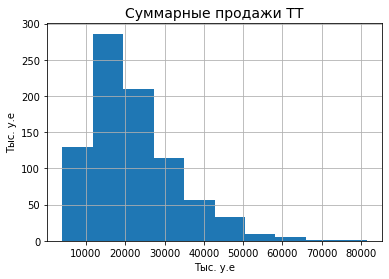

In [273]:
plt.hist(ttl_sales['total_items_sold']/1000)
plt.title('Суммарные продажи ТТ', size=14)
plt.xlabel('Тыс. у.е')
plt.ylabel('Тыс. у.е')
plt.grid()

### Рассмотрим данные по типам продуктов

In [274]:
ttl_sales_type=sales[['date', 'shop_id', 'goods_type', 'total_items_sold']].groupby(['shop_id', 'goods_type'], 
                                                                                    as_index=False).sum()
print(ttl_sales_type[['goods_type', #Кол-во ТТТ с данным типом продукта
                      'shop_id']].groupby(['goods_type'], 
                                                       as_index=False).count().rename(columns={'shop_id':'Кол-во ТТ'})) 

            goods_type  Кол-во ТТ
0               Бензак        845
1       Броня и одежда        775
2   Жидкости для тачки        777
3   Медпрепараты и еда        622
4    Модификации тачки        760
5               Оружие        718
6              Патроны        730
7              Солярка        806
8       Съедобный хлам        780
9                 Хлам        785
10           Ядер-Кола        676


In [275]:
# Данные по всем ТТ/типам товаров
all_shops_gtypes=pd.DataFrame(sales['shop_id'].unique()).assign(foo=1).merge(pd.DataFrame(sales['goods_type'].unique()).assign(foo=1), on='foo').drop('foo',1).rename(columns={'0_x':'shop_id','0_y':'goods_type'})
all_shops_gtypes=all_shops_gtypes.merge(ttl_sales_type, how='left').fillna(0)
all_shops_gtypes=all_shops_gtypes.merge(sales[['date', 'shop_id']].drop_duplicates().groupby('shop_id').count(), 
                          left_on='shop_id', right_on='shop_id',
                          how='left').rename(columns={"date": 'sl_days'})
all_shops_gtypes['sl_per_day']=all_shops_gtypes['total_items_sold']/all_shops_gtypes['sl_days']

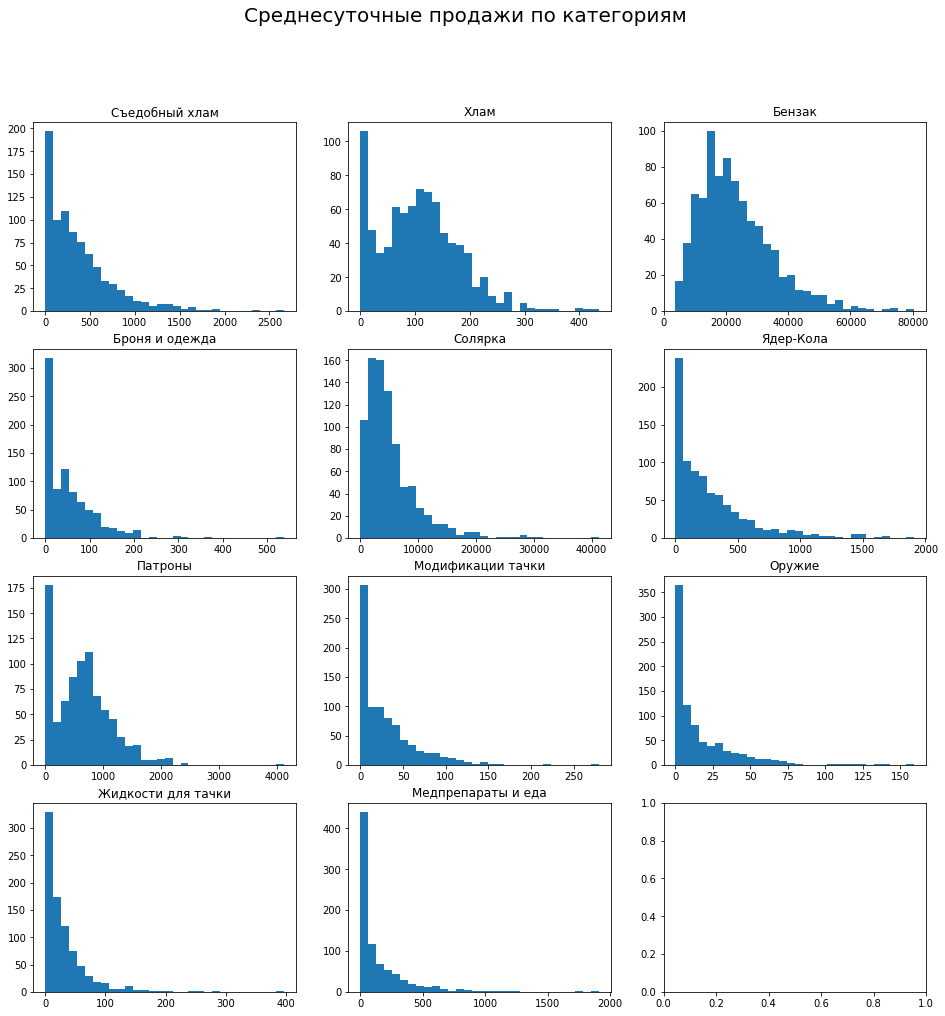

In [276]:
nrows=all_shops_gtypes['goods_type'].unique().shape[0]
fig, ax = plt.subplots(nrows=round(nrows/3), ncols=3, figsize=(16,16))
fig.suptitle('Среднесуточные продажи по категориям', size=20)
for i,j in enumerate(all_shops_gtypes['goods_type'].unique()):
    ax[i//3,i%3].hist(all_shops_gtypes.loc[all_shops_gtypes['goods_type']==j]['sl_per_day'], bins=30)
    ax[i//3,i%3].set_title(j)


Заметим, что в части ТТ категория могла перестать продаваться. Например категория 'Съедобный хлам' в Shop_id = 0:

C:\Users\aprotckii_mv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aprotckii_mv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


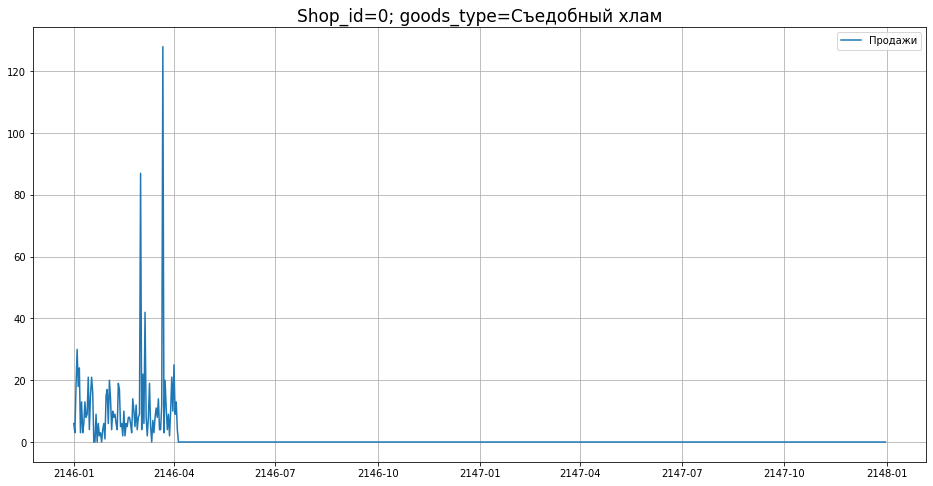

In [277]:
s_id=0
gt='Съедобный хлам'
dts=pd.DataFrame(pd.date_range(sales['date'].min(),sales['date'].max(),freq='D'),columns=['date'])
plt.figure(figsize=(16,8))
plt.plot(dts,
         dts.merge(sales.loc[(sales['shop_id']==s_id) & (sales['goods_type']==gt)], how='left')['total_items_sold'].fillna(0),
        label='Продажи')
plt.title(str('Shop_id='+str(s_id)+'; goods_type='+str(gt)), size=17)
plt.grid()
plt.legend()

### Определим долю категории товаров в суммарных продажах ТТ.

Т.к. категория могла быть выведена из <b>ассортиментной матрицы</b> ТТ в анализируемом периоде, определим присутствие/остутствие в матрице: 

если <b>95% квантиль</b> продаж по категории в ТТ больше 0, значит категория есть в ассортиментной матрице ТТ.

In [278]:
dts_shops=pd.DataFrame(dts.assign(foo=1).merge(pd.DataFrame(sales['shop_id'].unique()).assign(foo=1), 
                                               on='foo').drop('foo',1)).rename(columns={0:'shop_id'})
dts_shops_gtype=pd.DataFrame(dts_shops.assign(foo=1).merge(pd.DataFrame(sales['goods_type'].unique()).assign(foo=1), 
                                                           on='foo').drop('foo',1)).rename(columns={0:'goods_type'})
#%%
shop_gtype_med=dts_shops_gtype.merge(sales[['date','shop_id','goods_type','total_items_sold']],
                          left_on=['date','shop_id','goods_type'], 
                          right_on=['date','shop_id','goods_type'], 
                          how='left').fillna(0)[['shop_id','goods_type',
                'total_items_sold']].groupby(['shop_id','goods_type'], as_index=False).quantile(0.95) # 95% квантиль продаж категории в ТТ
#%%
not_in_matr=shop_gtype_med[shop_gtype_med['total_items_sold']==0].iloc[:,[0,1]] # нет в матрице в ТТ

In [279]:
not_in_matr

,shop_id,goods_type
1,0,Броня и одежда
2,0,Жидкости для тачки
3,0,Медпрепараты и еда
4,0,Модификации тачки
5,0,Оружие
...,...,...
9206,836,Ядер-Кола
9221,838,Медпрепараты и еда
9223,838,Оружие
9224,838,Патроны


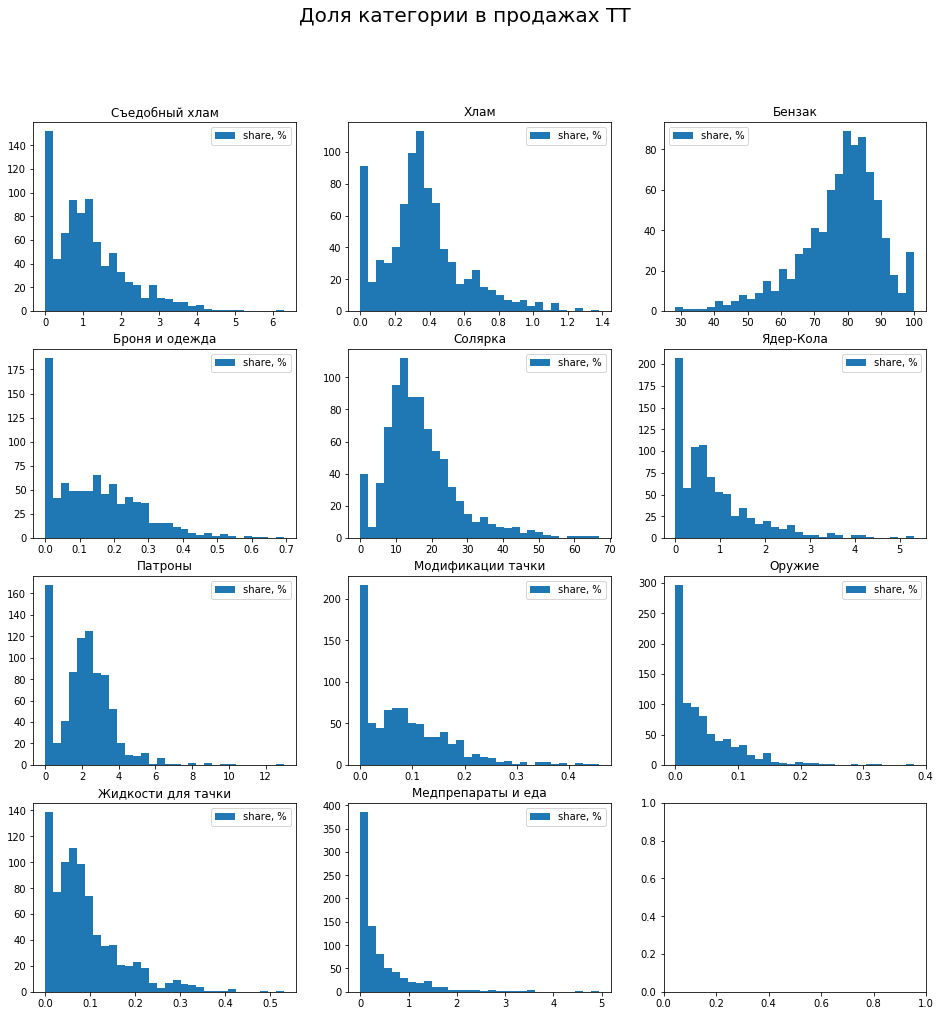

In [280]:
#%% Доля группы товаров в продажах ТТ
all_shops_gtypes['gtype_share']=all_shops_gtypes['total_items_sold']/all_shops_gtypes.merge(ttl_sales[['shop_id','total_items_sold']], 
    left_on='shop_id',
    right_on='shop_id', how='left')['total_items_sold_y']

nrows=len(all_shops_gtypes['goods_type'].unique())
fig, ax = plt.subplots(nrows=round(nrows/3), ncols=3, figsize=(16,16))
fig.suptitle('Доля категории в продажах ТТ', size=20)
for i,j in enumerate(all_shops_gtypes['goods_type'].unique()):
    ax[i//3,i%3].hist(all_shops_gtypes[all_shops_gtypes['goods_type']==j]['gtype_share']*100, bins=30, label='share, %')
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_title(j)

### Рассотрим структуру собственников ТТ

Проверим, могла ли ТТ менять собственника в анализируемый период.

In [281]:
count_owners=sales[['shop_id','owner']].drop_duplicates().groupby('shop_id', as_index=False).count()
print(count_owners['owner'].value_counts()) # Меняли собственника

1    688
2    157
Name: owner, dtype: int64


Заметим, что <b>157 ТТ меняли собственника</b> в анализируемый период. Переменная 'owner' будет исключена из дальнейшего анализа.

### Рассотрим переменную числа работников ТТ

Обратим внимание, что число работников в ТТ может быть <b>не постоянно</b>. Исходя из предположения, что для каждой ТТ есть определнное кол-во касс/зон обслуживания, определим число работников, как <b>медиану</b> по переменной 'number_of_counters'

C:\Users\aprotckii_mv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\aprotckii_mv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\aprotckii_mv\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'Число работников')

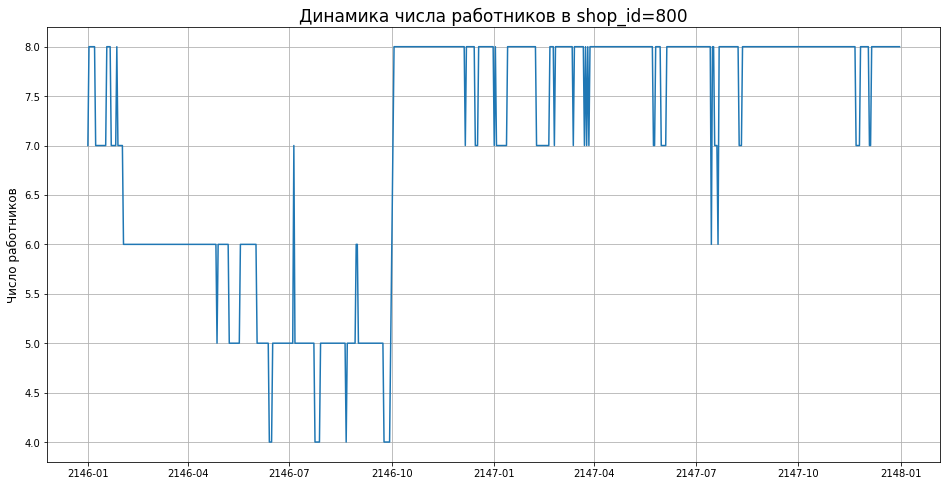

In [282]:
plt.figure(figsize=(16,8))
plt.plot(sales.loc[sales['shop_id']==800][['date', 'number_of_counters']].drop_duplicates()['date'],
         sales.loc[sales['shop_id']==800][['date', 'number_of_counters']].drop_duplicates()['number_of_counters'])
plt.grid()
plt.title('Динамика числа работников в shop_id=800', size=17)
plt.ylabel('Число работников', size=12)

Text(0, 0.5, 'К-во ТТ')

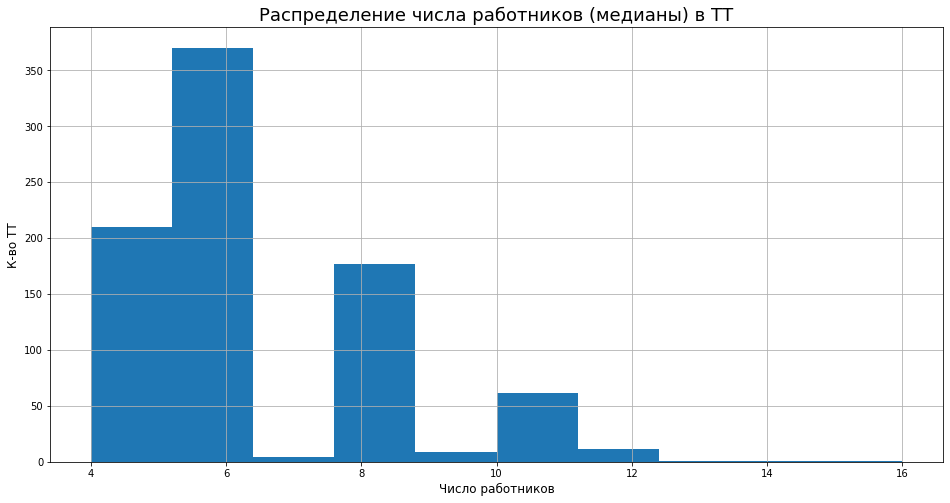

In [283]:
shop_m_workers=sales[['shop_id','date', 
                      'number_of_counters']].drop_duplicates()[['shop_id',
                                                                'number_of_counters']].groupby('shop_id', 
                                                                                               as_index=False).median()
plt.figure(figsize=(16,8))
plt.hist(shop_m_workers['number_of_counters']) # число работников в магазинах
plt.grid()
plt.title('Распределение числа работников (медианы) в ТТ', size=18)
plt.xlabel('Число работников', size=12)
plt.ylabel('К-во ТТ', size=12)

In [284]:
print(shop_m_workers['number_of_counters'].value_counts()) # число работников (медиана) в ТТ

6     370
4     196
8     177
10     59
5      14
12     11
9       9
7       4
11      2
16      1
14      1
13      1
Name: number_of_counters, dtype: int64


### Рассмотрим распределение продаж на 1 работающего сотрудника в ТТ

Text(0, 0.5, 'К-во ТТ')

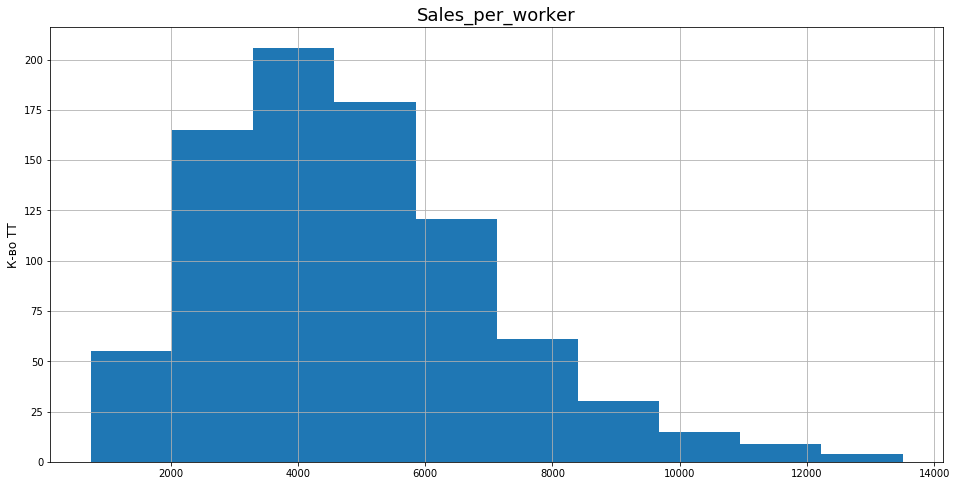

In [285]:
ttl_sales['sales_per_worker']=ttl_sales['sl_per_day']/ttl_sales.merge(shop_m_workers, how='left')['number_of_counters']

plt.figure(figsize=(16,8))
plt.hist(ttl_sales['sales_per_worker'])
plt.title('Sales_per_worker', size=18)
plt.grid()
plt.ylabel('К-во ТТ', size=12)

# shops.parquet

Посмотрим на кол-во <b>пропусков</b> в данных:

In [286]:
shops.isnull().sum()

shop_id                          0
neighborhood                     0
city                            57
year_opened                      0
is_on_the_road                   7
is_with_the_well                60
is_with_additional_services     61
shop_type                      132
dtype: int64

### Рассмотрим переменную year_opened

In [287]:
shops['year_opened'].value_counts()

 2139    94
-1       63
 2132    55
 2141    52
 2142    51
 2137    41
 2140    36
 2138    32
 2130    27
 2131    27
 2126    24
 2133    24
 2136    21
 2125    20
 2135    19
 2129    18
 2127    18
 2134    16
 2128    15
 2116    14
 2115    14
 2143    14
 2105     9
 2118     8
 2124     8
 2106     8
 2108     8
 2101     8
 2102     7
 2096     6
 2103     6
 2093     6
 2123     6
 2094     5
 2099     5
 2104     5
 2090     5
 2091     4
 2117     4
 2114     4
 2109     4
 2111     4
 2113     4
 2095     3
 2092     3
 2098     3
 2100     3
 2112     3
 2097     2
 2107     2
 2110     2
 2119     1
 2089     1
 2086     1
 2085     1
 2074     1
Name: year_opened, dtype: int64

Корреляция Пирсона:
                     years  total_items_sold
years             1.000000         -0.248076
total_items_sold -0.248076          1.000000


Text(0, 0.5, 'Total продажи, тыс. у.е')

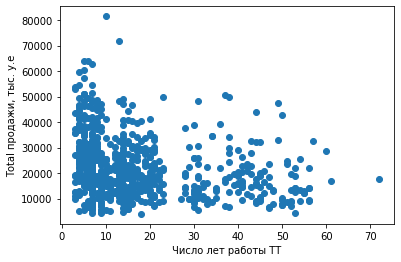

In [288]:
work_years=shops.loc[shops['year_opened']!=-1,['shop_id', 'year_opened']].merge(ttl_sales[['shop_id', 'total_items_sold']], 
                                                   left_on='shop_id', right_on='shop_id', 
                                                   how='left')
work_years['years']=2146-work_years['year_opened']
print('Корреляция Пирсона:')
print(work_years[['years','total_items_sold']].corr())
plt.scatter(work_years['years'], work_years['total_items_sold']/1000)
plt.xlabel('Число лет работы ТТ')
plt.ylabel('Total продажи, тыс. у.е')

Заметим, что пропуски в переменной <b>year_opened</b> заменены значением <b>-1</b>. Т.к. в анализируемый период Компания <b>не открывала новых ТТ</b>, все ТТ были открыты на момент начала анализируемого периода. К-т корреляции лет работы ТТ и ее совокупными продажами имеет отрицательный знак, но значение достаточно низкое по модулю.

Будем полагать, что 2 лет работы в нашем сегменте достаточно для ТТ, чтобы сформировать устойчивую клиентскую базу, ассортиментную политику и т.п.,переменную <b>year_opened</b> исключим из дальнейшего анализа.

In [289]:
shops['neighborhood'].value_counts()

В центре     309
У тоннеля    169
На отшибе    115
У ночлега     81
У воды        77
Промзона      62
С краю        32
Name: neighborhood, dtype: int64

Заметим, что бОльшая часть ТТ находится <b>"В центре"</b>. Для дальнейшего анализа <b>преобразуем переменную 'neighborhood' в бинарную</b>, где 1 - ТТ "В центре", 0 - ТТ "Не в центре"

## Обработка пропусков в данных

Видим 5 переменных с пропущенными значениями: 3 бинарных (is_on_the_road, is_with_the_well, is_with_additional_services), 2 категориальных (shop_type, city).


<b>Создадим классификатор</b>, с помощью которого заменим пропущенные значения в переменных в следующем порядке:

is_on_the_road', 'is_with_the_well', 'is_with_additional_services', 'shop_type'.


Т.к. у переменной 'city' большое число классов <b>(15 городов)</b>, будет непросто добиться высокого качества классификации.

Для решения этой проблемы, сначала <b>классифицируем ТТ по регионам</b> (переменная 'location'), после чего произведем классификацию по городам <b>внутри регионов</b>.


### Предобработка данных для классификатора

In [290]:
df=shops.merge(ttl_sales[['shop_id','sales_per_worker']], how='left')

df=df.merge(shop_m_workers, how='left')

df_gt=all_shops_gtypes.merge(shop_gtype_med,
                       left_on=['shop_id',
                                                'goods_type'],
                       right_on=['shop_id',
                                 'goods_type'],
                       how='left').rename(columns={'total_items_sold_y':'in_matrix'})
df_gt['in_matrix']=df_gt['in_matrix'].apply(lambda x: 1 if x>0 else 0)
df_gt['gtype_share_cor']=df_gt['gtype_share']*df_gt['in_matrix']
df_gt=df_gt.iloc[:,[0,1,7]]
df_gt=df_gt.pivot(index='shop_id', columns='goods_type', values='gtype_share_cor') #преобразуем доли категорий в ТТ в отдельные признаки для каждой категории

df['neighborhood'].value_counts()

df['В центре']=df['neighborhood'].apply(lambda x: 1 if x=='В центре' else 0) #преобразуем категориальный признак в бинарный относительно "В центре"

df=df.merge(df_gt, left_on='shop_id', right_on='shop_id', how='left')
df.replace(['да', 'нет'], [1,0], inplace=True)
df=df.merge(cities, left_on='city', right_on='city', how='left')

### Классификатор пропущенных значений

In [291]:
fet=['sales_per_worker', 'number_of_counters', 'В центре', 'Бензак',
       'Броня и одежда', 'Жидкости для тачки', 'Медпрепараты и еда',
       'Модификации тачки', 'Оружие', 'Патроны', 'Солярка', 'Съедобный хлам',
       'Хлам', 'Ядер-Кола']

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, random_state=1),
    SVC(gamma=2, C=1, random_state=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=1),
    DecisionTreeClassifier(max_depth=8, random_state=1),
    RandomForestClassifier(max_depth=8, n_estimators=15, max_features=1, random_state=1),
    MLPClassifier(alpha=1, max_iter=1000, random_state=1),
    AdaBoostClassifier(random_state=1),
    GaussianNB()
    ]

df_normalized=df.copy()
for i in fet:
    df_normalized[i]=normalize([df_normalized[i]]).reshape(-1,1)
    
location_arr=cities['location'].unique()

parameter_grid = {'criterion': ['entropy', 'gini'],
                        'max_depth': [10, 30, 100],
                        'n_estimators': [10, 30, 100]} # RF гиперпараметры

In [292]:
def classification(X, y, X_na, names, classifiers, parameter_grid):
    # Х - трейн дата, y - тест дата, X_na - Х для классификации,
    #classifiers - классификаторы, parameter_grid - RF гиперпараметры
    clf = RandomForestClassifier(random_state=1, class_weight='balanced_subsample')
    grid_searcher = GridSearchCV(clf, parameter_grid)
    grid_searcher.fit(X, y)
    clf_best = grid_searcher.best_estimator_
    y_hat=clf_best.predict(X_na)          
    max_score=grid_searcher.best_score_
    best_clf='RF_corr'
    d={best_clf:max_score}
    
    for name, clf in zip(names, classifiers):
        d[name] = cross_val_score(clf, X, y, cv=5).mean()
        if d[name] > max_score:
            max_score=d[name]
            best_clf = name
            clf.fit(X, y)
            y_hat=clf.predict(X_na)
    print('best clf: ',best_clf, ' best score: ', max_score)                
    return y_hat.reshape(-1,1)

In [293]:
%%time
fet_to_class=['is_on_the_road', 'is_with_the_well', 'is_with_additional_services', 'shop_type', 
              'location', 'city']
fet_to_class_w=['shop_type', 'location']

for i in fet_to_class:
    X=df_normalized.loc[(df_normalized[i].isnull()==False), fet]
    y=df_normalized.loc[(df_normalized[i].isnull()==False), i]
    X_na=df_normalized.loc[(df_normalized[i].isnull()), fet]
    if i != 'city':
        print(i)
        df_normalized.loc[(df_normalized[i].isnull()), i]=classification(X, y, X_na, names, classifiers, parameter_grid)

        if i not in fet_to_class_w:
            fet.append(i)
    else:
        
        for j in location_arr:
            print(i,' ',j)
            X=df_normalized.loc[(df_normalized['city'].isnull()==False) &
                              (df_normalized['location']==j), fet]
            y=df_normalized.loc[(df_normalized['city'].isnull()==False) &
                              (df_normalized['location']==j), 'city']
            X_na=df_normalized.loc[(df_normalized['city'].isnull()) &
                              (df_normalized['location']==j), fet]
            
            df_normalized.loc[(df_normalized['city'].isnull()) & 
                              (df_normalized['location']==j), 
                              'city']=classification(X, y, X_na, names, classifiers, parameter_grid) # замена NA прогнозами

is_on_the_road
best clf:  Gaussian Process  best score:  0.851988879384089
is_with_the_well
best clf:  RF_corr  best score:  0.9388535031847134
is_with_additional_services
best clf:  RF_corr  best score:  0.7270700636942674
shop_type
best clf:  RF_corr  best score:  0.7854821235102925
location
best clf:  RF_corr  best score:  0.7816737885995325
city   Скалистый Могильник
best clf:  RF_corr  best score:  0.6428571428571429
city   Свистящие Степи
best clf:  RF_corr  best score:  0.6425324675324675
city   Радиоактивная Пустошь
best clf:  RF_corr  best score:  0.6413661202185792
Wall time: 5min 1s


In [294]:
#%% DF после классификации NA

df_corr=df[['shop_id', 'neighborhood', 'sales_per_worker', 'number_of_counters', 'В центре', 'Бензак',
       'Броня и одежда', 'Жидкости для тачки', 'Медпрепараты и еда',
       'Модификации тачки', 'Оружие', 'Патроны', 'Солярка', 'Съедобный хлам',
       'Хлам', 'Ядер-Кола']].merge(df_normalized[['shop_id', 'city', 'location', 'is_on_the_road',
                                                  'is_with_the_well', 'is_with_additional_services', 'shop_type']], 
                                                  left_on='shop_id', 
                                                  right_on='shop_id', how='left')

### Рассчитаем доли продаж ТТ в своем городе / локации

In [295]:
city_sales=df_corr.merge(ttl_sales[['shop_id', 'total_items_sold']], 
              how='left')[['city','total_items_sold']].groupby('city', 
                                                               as_index=False).sum().rename(columns={'total_items_sold':'city_sales'})

df_corr['tt_in_city_share']=df_corr.merge(ttl_sales[['shop_id', 
                         'total_items_sold']], 
              how='left')['total_items_sold']/df_corr.merge(city_sales, 
                                                            left_on='city', right_on='city', 
                                                            how='left')['city_sales']

loc_sales=df_corr.merge(ttl_sales[['shop_id', 'total_items_sold']], 
              how='left')[['location','total_items_sold']].groupby('location', 
                                                               as_index=False).sum().rename(columns={'total_items_sold':'loc_sales'})

df_corr['tt_in_loc_share']=df_corr.merge(ttl_sales[['shop_id', 
                         'total_items_sold']], 
              how='left')['total_items_sold']/df_corr.merge(loc_sales, 
                                                            left_on='location', right_on='location', 
                                                            how='left')['loc_sales']     

Text(0, 0.5, 'К-во ТТ')

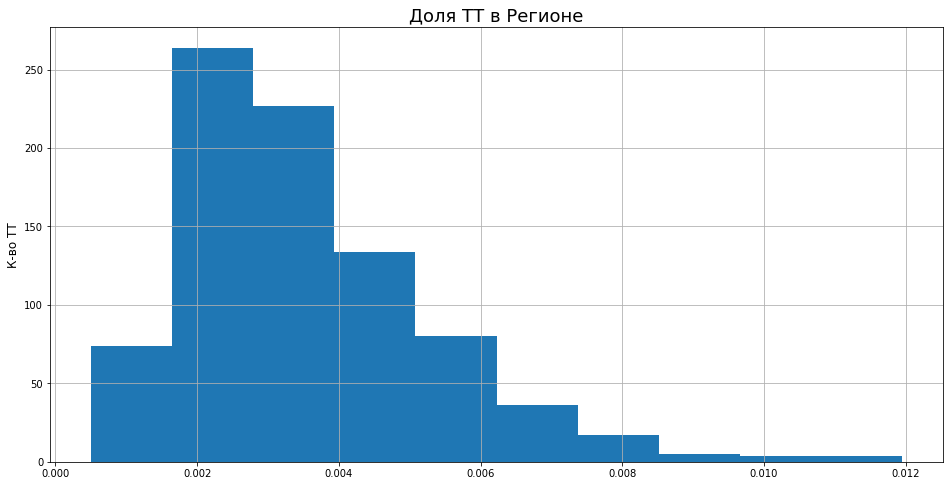

In [296]:
plt.figure(figsize=(16,8))
plt.hist(df_corr['tt_in_loc_share'])
plt.title('Доля ТТ в Регионе', size=18)
plt.grid()
plt.ylabel('К-во ТТ', size=12)

Text(0, 0.5, 'К-во ТТ')

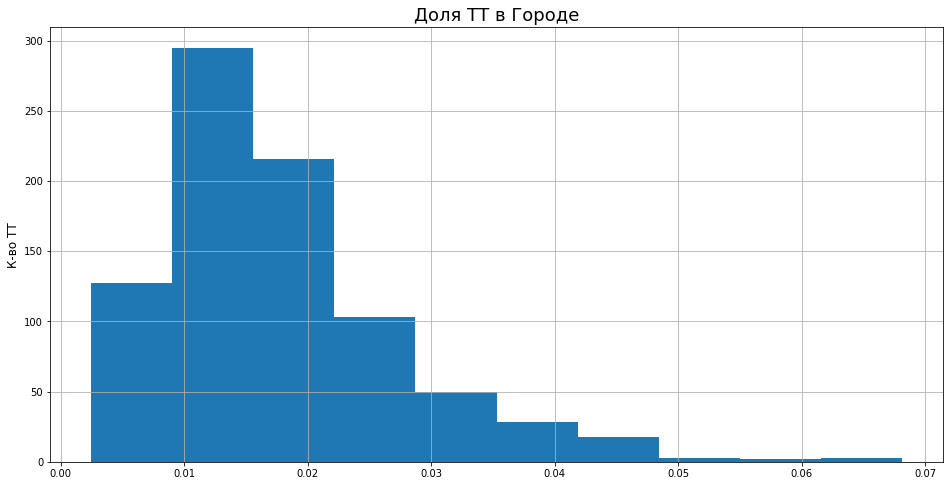

In [297]:
plt.figure(figsize=(16,8))
plt.hist(df_corr['tt_in_city_share'])
plt.title('Доля ТТ в Городе', size=18)
plt.grid()
plt.ylabel('К-во ТТ', size=12)

# Стандартизация признаков

На гистограммах выше видим, что в числовых признаках могут встречаться "выбросы", как в значении 0 (для признаков, характеризующих долю категории в ТТ), так и в "правом хвосте" (для признаков доли ТТ в городе/регионе).

Для того, чтобы распределия числовых признаков были более походими на нормальное, используем логарифм:

Ln(X_i), если X > 0;

Ln(X_i+min(X)/2), если хотябы один X = 0

После логарифмирования стандартизируем признаки.

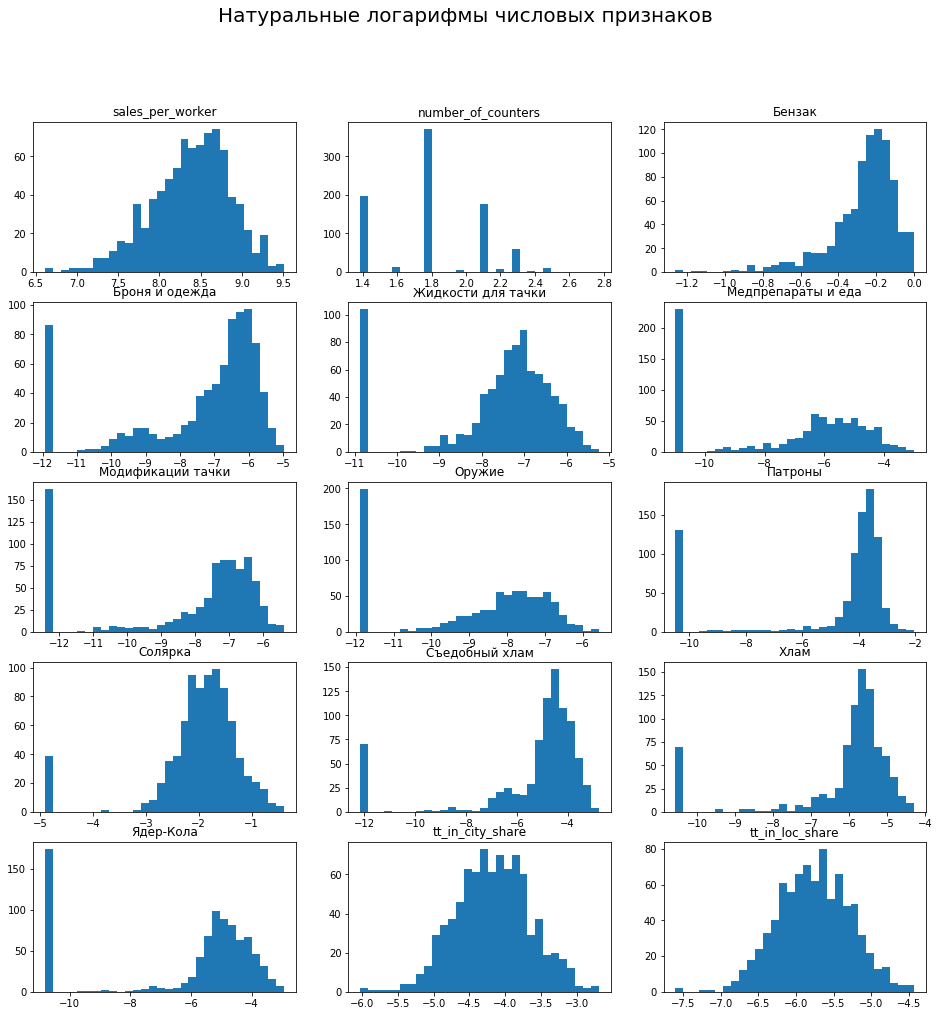

In [298]:
df_corr_normalized=df_corr.copy()

fet=['sales_per_worker', 'number_of_counters',
       'Бензак', 'Броня и одежда', 'Жидкости для тачки',
       'Медпрепараты и еда', 'Модификации тачки', 'Оружие', 'Патроны',
       'Солярка', 'Съедобный хлам', 'Хлам', 'Ядер-Кола', 
       'tt_in_city_share', 'tt_in_loc_share'] #'shop_type', 'В центре', 'is_on_the_road', 'is_with_the_well', 'is_with_additional_services',


nrows=len(fet)
fig, ax = plt.subplots(nrows=round(nrows/3), ncols=3, figsize=(16,16))
fig.suptitle('Натуральные логарифмы числовых признаков', size=20)
for i,j in enumerate(fet): # логарифмируем числовые признаки
    if df_corr[j].min()>0:
        
        df_corr_normalized[j]=np.log(df_corr[j])
        ax[i//3,i%3].hist(df_corr_normalized[j], bins=30)
    else:
        df_corr_normalized[j]=np.log(df_corr[j]+df_corr.loc[df_corr[j]>0, j].min()/2)
        ax[i//3,i%3].hist(df_corr_normalized[j], bins=30)
    #ax[i].legend()
    ax[i//3,i%3].set_title(j)

sc=StandardScaler().fit_transform(df_corr_normalized[fet]) #стандартизация числовых признаков
for i,j in enumerate(fet):
    df_corr_normalized[j]=sc[:,i].reshape(-1,1)

Преобразуем переменную <b>'shop_type'</b> из категориальной в 4 бинарных переменных, в соответствии со значением 'shop_type'

In [299]:
for i in df_corr_normalized['shop_type'].unique():
    df_corr_normalized['shop_type'+i]=df_corr_normalized['shop_type'].apply(lambda x: 1 if x==i else 0)

# Кластеризация

Для калибровки параметров методов кластеризации будем использовать <b>Davies–Bouldin index</b> (чем меньше, тем лучше разделение между кластерами) и <b>Calinski-Harabasz Index</b> (чем больше, тем более четко определены кластеры)

In [300]:
fet=['sales_per_worker', 'number_of_counters',
       'В центре', 'Бензак', 'Броня и одежда', 'Жидкости для тачки',
       'Медпрепараты и еда', 'Модификации тачки', 'Оружие', 'Патроны',
       'Солярка', 'Съедобный хлам', 'Хлам', 'Ядер-Кола', 'is_on_the_road', 'is_with_additional_services', 'is_with_the_well', 
       'tt_in_city_share', 'tt_in_loc_share', 'shop_type1', 'shop_type2', 'shop_type3', 'shop_type4']
X=df_corr_normalized[fet]
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
data_2d_tsne = tsne.fit_transform(X) #2-мерное пространство для визуализации

### MeanShift

In [301]:
%%time

labels_arr=[]
ms_clust_score=[]
l=np.linspace(2.7, 5 ,num=10) #1st range (2.7, 5) 2nd (2,2.7)
for i in l:
    ms = MeanShift(bandwidth=i)
    ms.fit(X)
    labels = ms.labels_
    labels_arr.append([i,np.unique(labels).shape[0]])
    if np.unique(labels).shape[0]>1:
        ms_clust_score.append([i,davies_bouldin_score(X, labels), calinski_harabasz_score(X, labels)])
    
labels_arr=np.array(labels_arr)
ms_clust_score=np.array(ms_clust_score)
bnd_opt=ms_clust_score[ms_clust_score[:,1].argmin(),0]
#%% MeanShift optimal
ms = MeanShift(bandwidth=bnd_opt)
ms.fit(X)
labels=ms.labels_

Wall time: 31.4 s


Text(0.5, 1.0, 'Кластеры веделеные алгоритмом MeanShift')

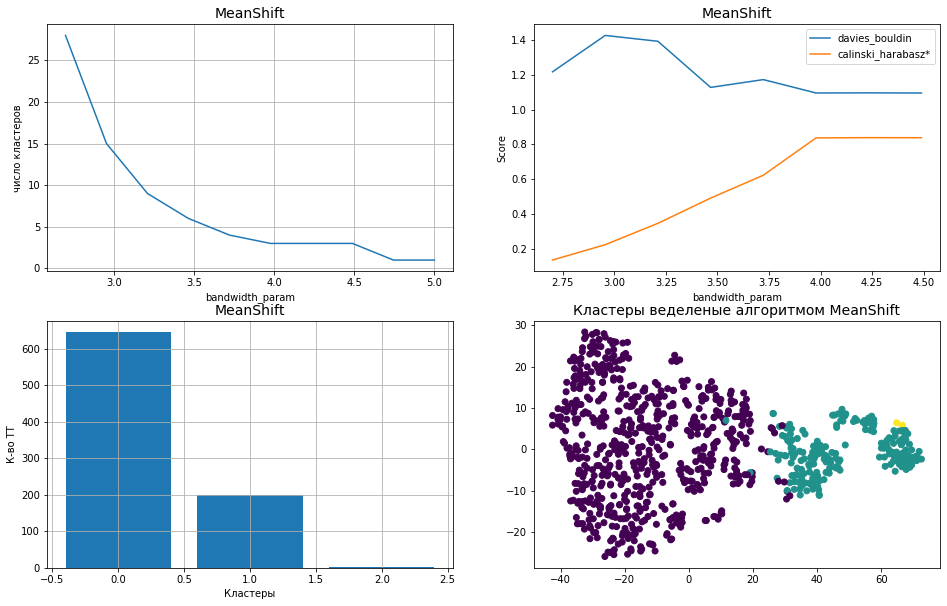

In [302]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10))
ax[0,0].plot(labels_arr[:,0],labels_arr[:,1])
ax[0,0].set_xlabel('bandwidth_param')
ax[0,0].set_ylabel('число кластеров')
ax[0,0].grid()
ax[0,0].set_title('MeanShift', size=14)

ax[0,1].plot(ms_clust_score[:,0],ms_clust_score[:,1], label='davies_bouldin')
ax[0,1].plot(ms_clust_score[:,0],ms_clust_score[:,2]/400, label='calinski_harabasz*')
ax[0,1].set_xlabel('bandwidth_param')
ax[0,1].legend()
ax[0,1].set_ylabel('Score')
ax[0,1].set_title('MeanShift', size=14)

ax[1,0].bar(pd.DataFrame(labels).iloc[:,0].unique(),pd.DataFrame(labels).value_counts())
ax[1,0].set_title('MeanShift', size=14)
ax[1,0].set_xlabel('Кластеры')
ax[1,0].set_ylabel('К-во ТТ')
ax[1,0].grid()

ax[1,1].scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c=labels)
ax[1,1].set_title('Кластеры веделеные алгоритмом MeanShift', size=14)

### DBSCAN

In [303]:
#%% DBSCAN выбор n_clusters
db_n_clust=[]
db_clust_score=[]
for i in np.linspace(1,2.6, num=20): #1st range (1.75,3) 2nd (1,2.6)
    db = DBSCAN(eps=i, min_samples=20).fit(X)
    labels = db.labels_
    db_n_clust.append([i,np.unique(labels).shape[0]])
    if np.unique(labels).shape[0]>1:
        db_clust_score.append([i,davies_bouldin_score(X, labels), calinski_harabasz_score(X, labels)])

db_n_clust=np.array(db_n_clust)
db_clust_score=np.array(db_clust_score)
eps_opt=db_clust_score[db_clust_score[:,1].argmin(),0]
db = DBSCAN(eps=eps_opt, min_samples=20).fit(X)
labels = db.labels_

df_corr['class']=labels

Text(0.5, 1.0, 'Кластеры веделеные алгоритмом DBSCAN')

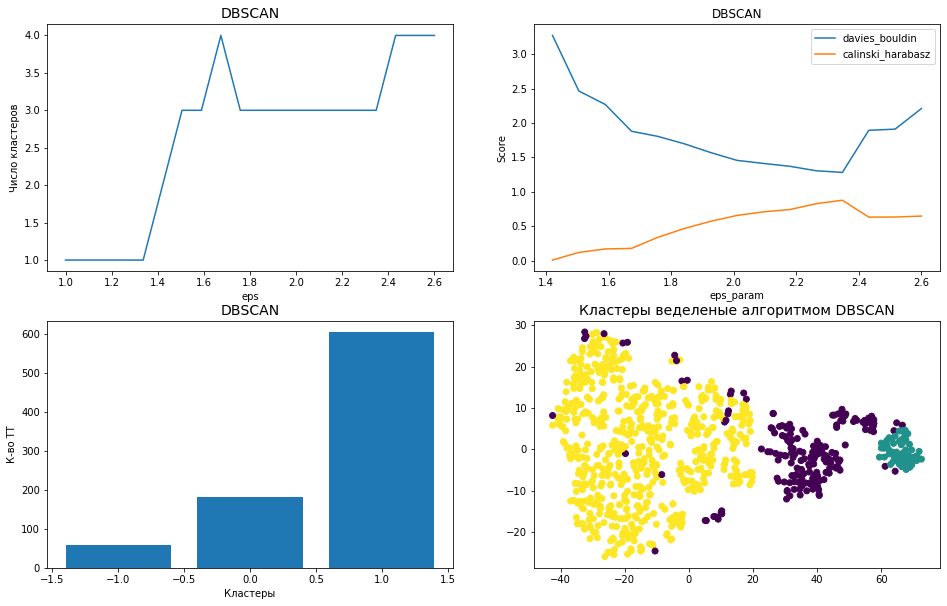

In [304]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

ax[0,0].plot(db_n_clust[:,0],db_n_clust[:,1])
ax[0,0].set_xlabel('eps')
ax[0,0].set_ylabel('Число кластеров')
ax[0,0].set_title('DBSCAN', size=14)
#pd.DataFrame(labels).hist(bins=labels.max())
#%% DBSCAN выбор n_clusters
ax[0,1].plot(db_clust_score[:,0],db_clust_score[:,1], label='davies_bouldin')
ax[0,1].plot(db_clust_score[:,0],db_clust_score[:,2]/400, label='calinski_harabasz')
ax[0,1].set_xlabel('eps_param')
ax[0,1].legend()
ax[0,1].set_ylabel('Score')
ax[0,1].set_title('DBSCAN')

ax[1,0].bar(pd.DataFrame(labels).iloc[:,0].unique(),pd.DataFrame(labels).value_counts())
ax[1,0].set_title('DBSCAN', size=14)
ax[1,0].set_xlabel('Кластеры')
ax[1,0].set_ylabel('К-во ТТ')

ax[1,1].scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c=labels)
ax[1,1].set_title('Кластеры веделеные алгоритмом DBSCAN', size=14)

In [305]:
#%% dendrogramm
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)   

Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis).')

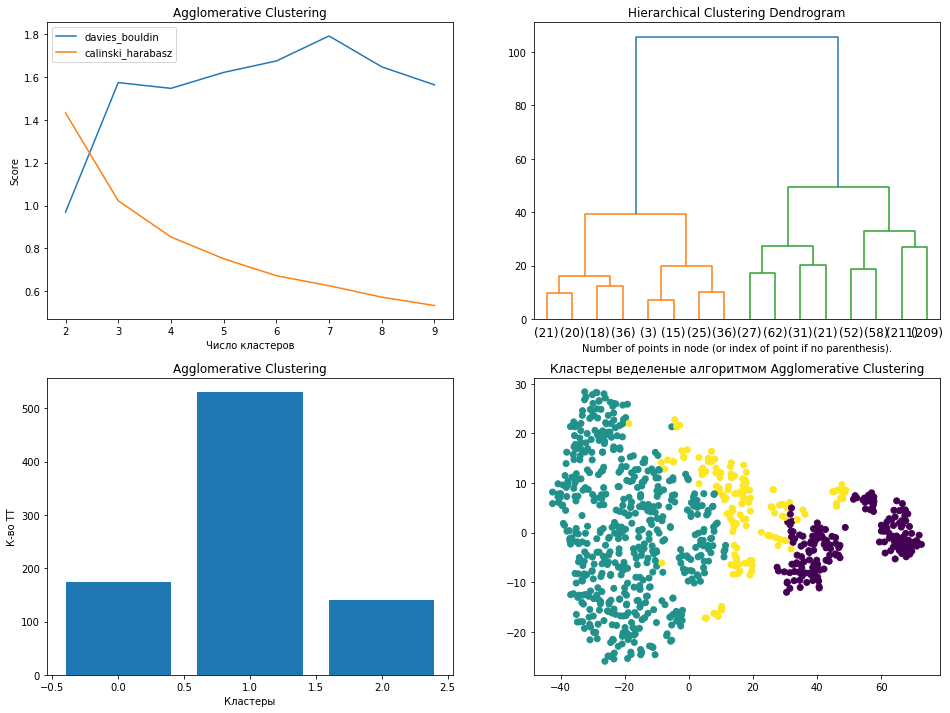

In [306]:
#%% Agglomerate выбор n_clusters
agg_clust_score=[]

for i in range(2,10):
    model = AgglomerativeClustering(n_clusters=i)
    model = model.fit(X)
    labels = model.labels_
    agg_clust_score.append([i,davies_bouldin_score(X, labels), calinski_harabasz_score(X, labels)])

agg_clust_score=np.array(agg_clust_score)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,12))

ax[0,0].plot(np.array(agg_clust_score)[:,0],np.array(agg_clust_score)[:,1], label='davies_bouldin')
ax[0,0].plot(np.array(agg_clust_score)[:,0],np.array(agg_clust_score)[:,2]/400, label='calinski_harabasz')
ax[0,0].set_xlabel('Число кластеров')
ax[0,0].legend()
ax[0,0].set_ylabel('Score')
ax[0,0].set_title('Agglomerative Clustering')

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=3)
model = model.fit(X)
labels=model.labels_


ax[1,0].bar(pd.DataFrame(labels).iloc[:,0].unique(),pd.DataFrame(labels).value_counts())
ax[1,0].set_title('Agglomerative Clustering')
ax[1,0].set_xlabel('Кластеры')
ax[1,0].set_ylabel('К-во ТТ')

ax[1,1].scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c=labels)
ax[1,1].set_title('Кластеры веделеные алгоритмом Agglomerative Clustering')

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)
ax[0,1].set_title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3, ax=ax[0,1])
ax[0,1].set_xlabel("Number of points in node (or index of point if no parenthesis).")
#ax[0,1].show()

### KMeans

Text(0.5, 1.0, 'Кластеры веделеные алгоритмом KMeans, k=3')

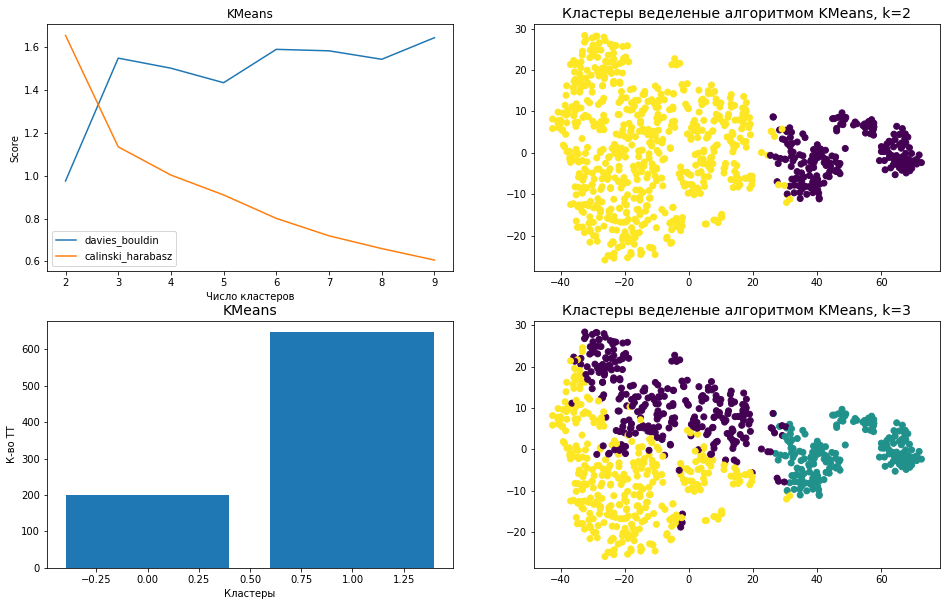

In [307]:
#%% KMeans выбор n_clusters
km_clust_score=[]

for i in range(2,10):
    model = KMeans(n_clusters=i, random_state=0)
    model = model.fit(X)
    labels = model.labels_
    km_clust_score.append([i,davies_bouldin_score(X, labels), calinski_harabasz_score(X, labels)])
    
model = KMeans(n_clusters=2, random_state=0)
model = model.fit(X)
labels = model.labels_
km_clust_score=np.array(km_clust_score)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

ax[0,0].plot(np.array(km_clust_score)[:,0],np.array(km_clust_score)[:,1], label='davies_bouldin')
ax[0,0].plot(np.array(km_clust_score)[:,0],np.array(km_clust_score)[:,2]/400, label='calinski_harabasz')
ax[0,0].set_xlabel('Число кластеров')
ax[0,0].legend()
ax[0,0].set_ylabel('Score')
ax[0,0].set_title('KMeans')

# setting distance_threshold=0 ensures we compute the full tree.
ax[0,1].scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c=labels)
ax[0,1].set_title('Кластеры веделеные алгоритмом KMeans, k=2', size=14)

ax[1,0].bar(pd.DataFrame(labels).iloc[:,0].unique(),pd.DataFrame(labels).value_counts())
ax[1,0].set_title('KMeans', size=14)
ax[1,0].set_xlabel('Кластеры')
ax[1,0].set_ylabel('К-во ТТ')

model = KMeans(n_clusters=3, random_state=0)
model = model.fit(X)
labels = model.labels_

ax[1,1].scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c=labels)
ax[1,1].set_title('Кластеры веделеные алгоритмом KMeans, k=3', size=14)

### Выбор метода кластеризации

Лучшие метрики показывают Аггломеративная кластеризация и KMeans при обучении для 2 кластеров. Предположим, что наша выборка содержит как минимум 3 группы ТТ, содержательно отличающихся между собой. Тогда:

In [308]:
print('DBSCAN:\n davies_bouldin= ',
      round(db_clust_score[db_clust_score[:,1].argmin()][1],2),
      ' calinski_harabasz= ', round(db_clust_score[db_clust_score[:,1].argmin()][2],2))
print('MeanShift:\n davies_bouldin= ',
      round(ms_clust_score[ms_clust_score[:,1].argmin()][1],2),
      ' calinski_harabasz= ', round(ms_clust_score[ms_clust_score[:,1].argmin()][2],2))
print('Agglomerative Clustering:\n davies_bouldin= ',
      round(agg_clust_score[1,1],2),
      ' calinski_harabasz= ', agg_clust_score[1,2])
print('KMeans:\n davies_bouldin= ',
      round(km_clust_score[1,1],2),
      ' calinski_harabasz= ', round(km_clust_score[1,2],2))

DBSCAN:
 davies_bouldin=  1.28  calinski_harabasz=  351.08
MeanShift:
 davies_bouldin=  1.1  calinski_harabasz=  335.28
Agglomerative Clustering:
 davies_bouldin=  1.57  calinski_harabasz=  409.131912051644
KMeans:
 davies_bouldin=  1.55  calinski_harabasz=  454.1


Как видим, лучшим по криетрию 'davies_bouldin index' признается <b>MeanShift</b> кластеризация. Заметим, что при использовании данного метода кластеризации, наблюдаем знаительный <b>дисбаланс</b> по кол-ву элементов в кластерах - только 2 ТТ попадают в класстер 2.

Вторым по качеству критерия 'davies_bouldin index' является метод <b>DBSCAN</b>, который также превосходит метод MeanShift по индексу 'calinski_harabasz'. Определим метод <b>DBSCAN</b>, как итоговый метод кластеризации.

# Интерпретация кластеров

In [309]:
db_labels.value_counts()

 0    621
-1    119
 1     62
 2     43
dtype: int64

2    369
0    282
1    194
dtype: int64

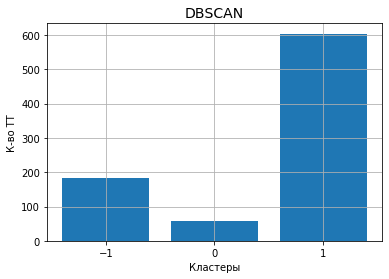

In [310]:
plt.bar([1,-1,0],df_corr['class'].value_counts())
plt.title('DBSCAN', size=14)
plt.xlabel('Кластеры')
plt.ylabel('К-во ТТ')
plt.grid()
plt.xticks([1,-1,0])
pd.DataFrame(labels).value_counts()

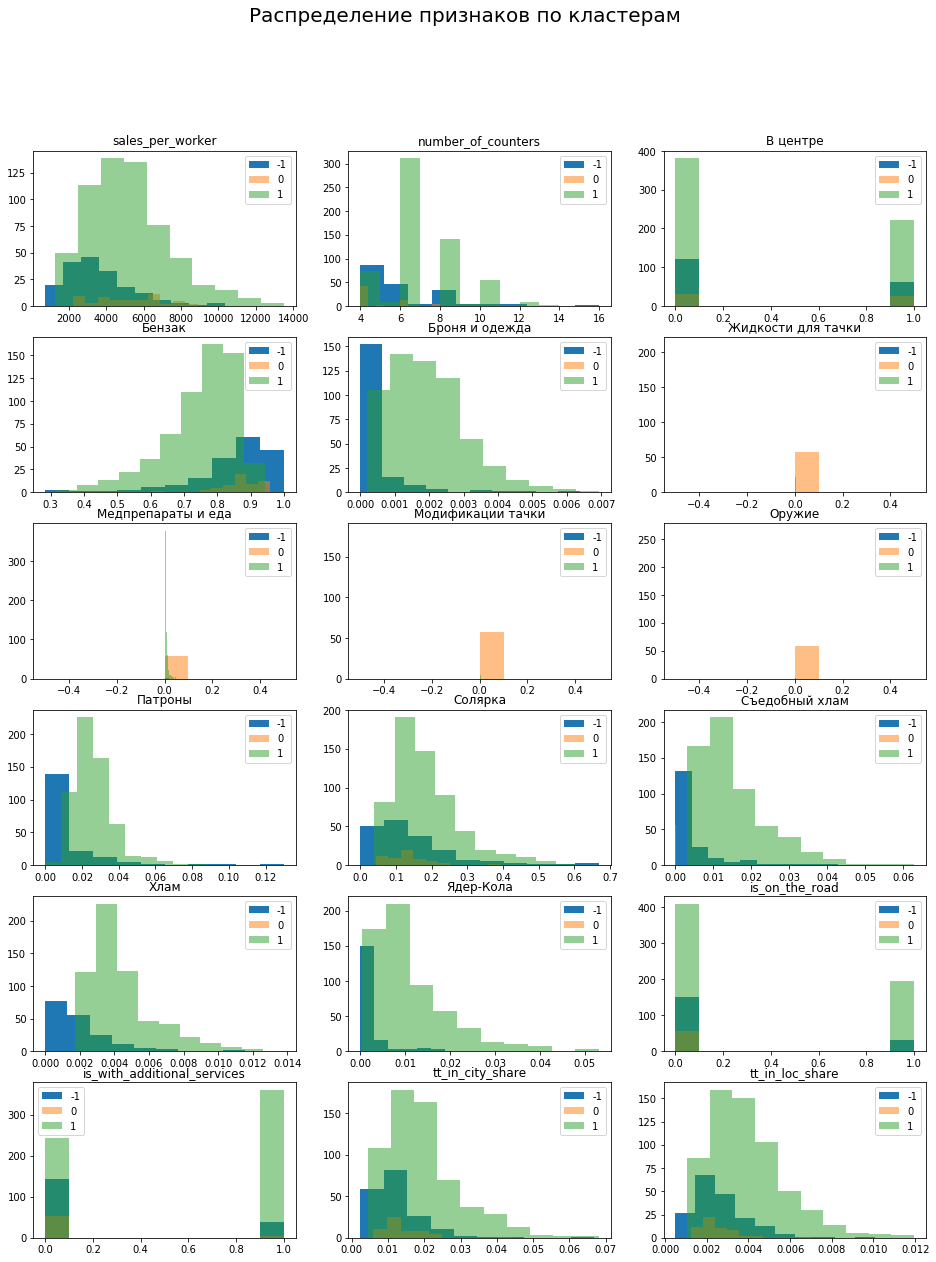

In [311]:
check=['sales_per_worker', 'number_of_counters',
       'В центре', 'Бензак', 'Броня и одежда', 'Жидкости для тачки',
       'Медпрепараты и еда', 'Модификации тачки', 'Оружие', 'Патроны',
       'Солярка', 'Съедобный хлам', 'Хлам', 'Ядер-Кола', 'is_on_the_road', 'is_with_additional_services',
       'tt_in_city_share', 'tt_in_loc_share']

fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(16,20))

fig.suptitle('Распределение признаков по кластерам', size=20)
for i,j in enumerate(check):
    ax[i//3,i%3].hist(df_corr[['shop_id',j,'class']].pivot(index='shop_id', columns='class', values=j)[-1], label='-1')
    ax[i//3,i%3].hist(df_corr[['shop_id',j,'class']].pivot(index='shop_id', columns='class', values=j)[0],alpha=0.5, label='0')
    ax[i//3,i%3].hist(df_corr[['shop_id',j,'class']].pivot(index='shop_id', columns='class', values=j)[1],alpha=0.5, label='1')
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_title(j)


In [312]:
print('Медианы признаков по кластерам:')
df_corr[['sales_per_worker', 'number_of_counters',
       'В центре', 'Бензак', 'Броня и одежда', 'Жидкости для тачки',
       'Медпрепараты и еда', 'Модификации тачки', 'Оружие', 'Патроны',
       'Солярка', 'Съедобный хлам', 'Хлам', 'Ядер-Кола', 'is_on_the_road', 'is_with_additional_services',
       'tt_in_city_share', 'tt_in_loc_share','class']].groupby('class', as_index=False).median()

Медианы признаков по кластерам:


,class,sales_per_worker,number_of_counters,В центре,Бензак,Броня и одежда,Жидкости для тачки,Медпрепараты и еда,Модификации тачки,Оружие,Патроны,Солярка,Съедобный хлам,Хлам,Ядер-Кола,is_on_the_road,is_with_additional_services,tt_in_city_share,tt_in_loc_share
0,-1,3247.408219,6,0,0.882070,0.000109,0.000228,0.000000,0.000000,0.000000,0.001515,0.108459,0.001919,0.001590,0.000000,0.0,0.0,0.010667,0.002359
1,0,5541.246062,4,0,0.875986,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.124014,0.000000,0.000000,0.000000,0.0,0.0,0.012161,0.002253
2,1,4932.252798,6,0,0.771082,0.001804,0.000879,0.003387,0.000966,0.000432,0.024790,0.162949,0.012222,0.003875,0.008274,0.0,1.0,0.017830,0.003587


In [313]:
print('Средние значения признаков по кластерам:')
df_corr[['sales_per_worker', 'number_of_counters',
       'В центре', 'Бензак', 'Броня и одежда', 'Жидкости для тачки',
       'Медпрепараты и еда', 'Модификации тачки', 'Оружие', 'Патроны',
       'Солярка', 'Съедобный хлам', 'Хлам', 'Ядер-Кола', 'is_on_the_road', 'is_with_additional_services',
       'tt_in_city_share', 'tt_in_loc_share','class']].groupby('class', as_index=False).mean()

Средние значения признаков по кластерам:


,class,sales_per_worker,number_of_counters,В центре,Бензак,Броня и одежда,Жидкости для тачки,Медпрепараты и еда,Модификации тачки,Оружие,Патроны,Солярка,Съедобный хлам,Хлам,Ядер-Кола,is_on_the_road,is_with_additional_services,tt_in_city_share,tt_in_loc_share
0,-1,3623.095685,5.808743,0.333333,0.848246,4.114554e-04,0.000362,0.000594,0.000198,0.000081,0.010309,0.131067,0.004646,0.002129,0.001937,0.174863,0.213115,0.012470,0.002634
1,0,5189.863556,4.655172,0.448276,0.869159,3.273080e-07,0.000000,0.000000,0.000000,0.000000,0.000004,0.130820,0.000003,0.000004,0.000003,0.034483,0.068966,0.014065,0.002494
2,1,5185.514730,6.710265,0.367550,0.749253,1.946750e-03,0.001130,0.005769,0.001127,0.000589,0.026284,0.183135,0.015113,0.004435,0.011219,0.321192,0.596026,0.019706,0.003930


# Алгоритм выделил 3 класстера:
- <b>'-1'</b> - <b>ТТ с низкой операционной эффективностью</b>. 183 ТТ; преимущественно малого и среднего размера (4-6 сотрудников); самый низкий показатель продаж на 1 работника; как правило, занимают наимельную долю продаж в своих Городах. Высокая доля <b>топливных категорий</b> (Бензак, Солярка), но в матрице присутствуют и нетопливные продукты (в бОльшей степени Съедобный Хлам, Хлам, Патроны, Жидкости для Тачки).


- <b>'0'</b> - <b>Топливноориентированные ТТ</b>. 58 ТТ; торговые точки "малого" формата - преимущественно по 4 сотрудника, демонстрируют самые высокие продажи на 1 сотрудника, занимают вторую долю по объемам продаж в своих Городах. Чаще остальных ТТ расположены "В центре", практически не встречаются "у дороги". Высокая доля <b>топливных категорий</b> (Бензак, Солярка), нетопливыне продукты пратически не присутствуют в матрицах данных ТТ. В торговых точках практически всегда отсутствуют "дополнительные сервисы и услуги".


- <b>'1'</b> - <b>ТТ с широким ассортиментом товаров и услуг</b>. 604 ТТ; как правило наиболее крупные ТТ - в основном по 6-8 сотрудников, занимают второе место по выручке на 1 работника; лидируют по доле продаж в своих Городах и Регионах. Значительно чаще остальных встречаются "У дороги". ТТ лидируют по доле <b>нетопливных категорий</b> (в топливном сегменте доля Солярки выше, чем у остальных типов ТТ), ассортиментная матрица у данного типа ТТ максимально разнообразна. Чаще всего в ТТ присутствуют "дополнительные сервисы и услуги"

### Проверим значимость отличия по признакам между кластерами

<b>Числовые</b> признаки сравним по клитерию Манна-Уитни:

H0: F_x1(x)=F_x2(x)

H1: F_x1(x)=F_x2(x+Q)

#### Классы 1 и -1

In [314]:
check=['sales_per_worker', 'number_of_counters',
       'Бензак', 'Броня и одежда', 'Жидкости для тачки',
       'Медпрепараты и еда', 'Модификации тачки', 'Оружие', 'Патроны',
       'Солярка', 'Съедобный хлам', 'Хлам', 'Ядер-Кола',
       'tt_in_city_share', 'tt_in_loc_share']
for i in check:
    print(i)
    mw=stats.mannwhitneyu(df_corr.loc[df_corr['class']==1, i], 
                   df_corr.loc[df_corr['class']==-1, i])[1]
    if mw>0.05:
        print('p-val=',mw,' - H0 не отвергается, распределения выборок равны')
    else:
        print('p-val=',mw,' - H0 отвергается, распределения выборок отличаются')


sales_per_worker
p-val= 3.206582632902099e-20  - H0 отвергается, распределения выборок отличаются
number_of_counters
p-val= 6.772750653470475e-11  - H0 отвергается, распределения выборок отличаются
Бензак
p-val= 5.495380772884049e-29  - H0 отвергается, распределения выборок отличаются
Броня и одежда
p-val= 3.840556619314667e-68  - H0 отвергается, распределения выборок отличаются
Жидкости для тачки
p-val= 1.125916371987422e-51  - H0 отвергается, распределения выборок отличаются
Медпрепараты и еда
p-val= 1.8383056435804952e-69  - H0 отвергается, распределения выборок отличаются
Модификации тачки
p-val= 1.406376342529891e-69  - H0 отвергается, распределения выборок отличаются
Оружие
p-val= 1.5270031517815484e-70  - H0 отвергается, распределения выборок отличаются
Патроны
p-val= 6.327913531730117e-50  - H0 отвергается, распределения выборок отличаются
Солярка
p-val= 1.4461527106790554e-12  - H0 отвергается, распределения выборок отличаются
Съедобный хлам
p-val= 6.7347882052492685e-59  - H0

Видим, различия между всем признаками значимы.

#### Классы 0 и -1

In [315]:
check=['sales_per_worker', 'number_of_counters',
       'Бензак', 'Броня и одежда', 'Жидкости для тачки',
       'Медпрепараты и еда', 'Модификации тачки', 'Оружие', 'Патроны',
       'Солярка', 'Съедобный хлам', 'Хлам', 'Ядер-Кола',
       'tt_in_city_share', 'tt_in_loc_share']
for i in check:
    print(i)
    mw=stats.mannwhitneyu(df_corr.loc[df_corr['class']==0, i], 
                   df_corr.loc[df_corr['class']==-1, i])[1]
    if mw>0.05:
        print('p-val=',mw,' - H0 не отвергается, распределения выборок равны')
    else:
        print('p-val=',mw,' - H0 отвергается, распределения выборок отличаются')

sales_per_worker
p-val= 1.3299246505272732e-08  - H0 отвергается, распределения выборок отличаются
number_of_counters
p-val= 3.6344919733148084e-05  - H0 отвергается, распределения выборок отличаются
Бензак
p-val= 0.49525739348003367  - H0 не отвергается, распределения выборок равны
Броня и одежда
p-val= 3.6945484552075585e-23  - H0 отвергается, распределения выборок отличаются
Жидкости для тачки
p-val= 1.7204809254563596e-19  - H0 отвергается, распределения выборок отличаются
Медпрепараты и еда
p-val= 0.0004211180617321507  - H0 отвергается, распределения выборок отличаются
Модификации тачки
p-val= 1.4860211269955078e-09  - H0 отвергается, распределения выборок отличаются
Оружие
p-val= 1.3169961378275993e-05  - H0 отвергается, распределения выборок отличаются
Патроны
p-val= 6.515249732889358e-14  - H0 отвергается, распределения выборок отличаются
Солярка
p-val= 0.1727618951541801  - H0 не отвергается, распределения выборок равны
Съедобный хлам
p-val= 6.129377615079927e-27  - H0 отверг

Видим, что различия между всеми признаками, кроме <b>топливных категорий</b> (Бензак, Солярка) и долей в Регионе значимы.

#### Классы 1 и 0

In [316]:
check=['sales_per_worker', 'number_of_counters',
       'Бензак', 'Броня и одежда', 'Жидкости для тачки',
       'Медпрепараты и еда', 'Модификации тачки', 'Оружие', 'Патроны',
       'Солярка', 'Съедобный хлам', 'Хлам', 'Ядер-Кола',
       'tt_in_city_share', 'tt_in_loc_share']
for i in check:
    print(i)
    mw=stats.mannwhitneyu(df_corr.loc[df_corr['class']==1, i], 
                   df_corr.loc[df_corr['class']==-1, i])[1]
    if mw>0.05:
        print('p-val=',mw,' - H0 не отвергается, распределения выборок равны')
    else:
        print('p-val=',mw,' - H0 отвергается, распределения выборок отличаются')

sales_per_worker
p-val= 3.206582632902099e-20  - H0 отвергается, распределения выборок отличаются
number_of_counters
p-val= 6.772750653470475e-11  - H0 отвергается, распределения выборок отличаются
Бензак
p-val= 5.495380772884049e-29  - H0 отвергается, распределения выборок отличаются
Броня и одежда
p-val= 3.840556619314667e-68  - H0 отвергается, распределения выборок отличаются
Жидкости для тачки
p-val= 1.125916371987422e-51  - H0 отвергается, распределения выборок отличаются
Медпрепараты и еда
p-val= 1.8383056435804952e-69  - H0 отвергается, распределения выборок отличаются
Модификации тачки
p-val= 1.406376342529891e-69  - H0 отвергается, распределения выборок отличаются
Оружие
p-val= 1.5270031517815484e-70  - H0 отвергается, распределения выборок отличаются
Патроны
p-val= 6.327913531730117e-50  - H0 отвергается, распределения выборок отличаются
Солярка
p-val= 1.4461527106790554e-12  - H0 отвергается, распределения выборок отличаются
Съедобный хлам
p-val= 6.7347882052492685e-59  - H0

Видим, различия между всем признаками значимы.

<b>Факторные признаки</b> сравним по Z-критерию для разности долей

In [317]:
import scipy

In [318]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [319]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [320]:
check=['В центре','is_on_the_road', 'is_with_additional_services']
print('Ксластер 1 vs кластер -1')
for i in check:
    t_df=df_corr[[i, 'class']].groupby('class', as_index=False).mean()
    if t_df[t_df['class']==1][i].values[0]>t_df[t_df['class']==-1][i].values[0]:
        pv=proportions_diff_z_test(proportions_diff_z_stat_ind(df_corr.loc[df_corr['class']==1, i], 
                                                                          df_corr.loc[df_corr['class']==-1, i]),
                              'greater')
    else:
        pv=proportions_diff_z_test(proportions_diff_z_stat_ind(df_corr.loc[df_corr['class']==1, i], 
                                                                          df_corr.loc[df_corr['class']==-1, i]),
                              'less')
    print(i, ": p-value: %f" % pv)

print('\nКсластер 0 vs кластер -1')
for i in check:
    t_df=df_corr[[i, 'class']].groupby('class', as_index=False).mean()
    if t_df[t_df['class']==0][i].values[0]>t_df[t_df['class']==-1][i].values[0]:
        pv=proportions_diff_z_test(proportions_diff_z_stat_ind(df_corr.loc[df_corr['class']==0, i], 
                                                                          df_corr.loc[df_corr['class']==-1, i]),
                              'greater')
    else:
        pv=proportions_diff_z_test(proportions_diff_z_stat_ind(df_corr.loc[df_corr['class']==0, i], 
                                                                          df_corr.loc[df_corr['class']==-1, i]),
                              'less')
    print(i, ": p-value: %f" % pv)

print('\nКсластер 0 vs кластер 1')
for i in check:
    t_df=df_corr[[i, 'class']].groupby('class', as_index=False).mean()
    if t_df[t_df['class']==0][i].values[0]>t_df[t_df['class']==1][i].values[0]:
        pv=proportions_diff_z_test(proportions_diff_z_stat_ind(df_corr.loc[df_corr['class']==0, i], 
                                                                          df_corr.loc[df_corr['class']==1, i]),
                              'greater')
    else:
        pv=proportions_diff_z_test(proportions_diff_z_stat_ind(df_corr.loc[df_corr['class']==0, i], 
                                                                          df_corr.loc[df_corr['class']==1, i]),
                              'less')
    print(i, ": p-value: %f" % pv)

Ксластер 1 vs кластер -1
В центре : p-value: 0.199056
is_on_the_road : p-value: 0.000063
is_with_additional_services : p-value: 0.000000

Ксластер 0 vs кластер -1
В центре : p-value: 0.056119
is_on_the_road : p-value: 0.003722
is_with_additional_services : p-value: 0.006235

Ксластер 0 vs кластер 1
В центре : p-value: 0.112517
is_on_the_road : p-value: 0.000002
is_with_additional_services : p-value: 0.000000


Видим, что на 10% уровне значимости не можем утверждать о различии доли числа ТТ "В центре" кластеров 0 и 1, 1 и -1, но на 10% уровне значимости можем отвергнуть гиподезу о равенстве долей числа ТТ "В центре" для кластеров 0 и -1. Таким образом, <b>"Топливноориентированные ТТ"</b> чаще расположены <b>"В центре"</b>, чем <b>"ТТ с низкой операционной эффективностью"</b>.

Показатели доли числа ТТ <b>"У дороги"</b> и доли ТТ с <b>"дополнительными сервисами и услугами"</b> значимо <b>различаются</b> для всех типов кластеров.

In [321]:
#df_corr.to_excel('df.xlsx')
df_corr[['shop_id','class']].to_csv('output.tsv',sep='\t', index=False)